## First let's build a synthetic dataset we know the equations for.
What we're doing is creating a 100 stack of 2D gaussians (dimensions 100x100x100). In time (or axis-z), the maximum amplitude of the 2D gaussians is also Gaussian: stacked_gaussiance[49] has the highest Gaussian.

### This code was modified from:
https://stackoverflow.com/questions/76782546/generate-several-smooth-curves-passing-through-a-given-set-of-points/76783390#76783390


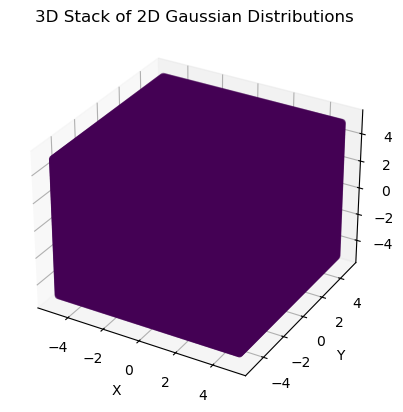

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define parameters for the 2D Gaussian distributions
x = np.linspace(-5, 5, 100)  # X-axis
y = np.linspace(-5, 5, 100)  # Y-axis
z = np.linspace(0, 1000, 100) # Z-axis
X, Y = np.meshgrid(x, y)

# Create a function to generate a 2D Gaussian distribution
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))

# Create a 3D stack of 2D Gaussian distributions
z_values = []
z_range = np.linspace(-5, 5, 100)  # Values along the Z-axis
for z in z_range:
    z_values.append(gaussian_2d(X, Y, 0, 0, 1, 1) * np.exp(-(z ** 2) / 2))  # Varying Z-component

# Convert the list of arrays into a 3D numpy array
stacked_gaussians = np.stack(z_values, axis=2)

# Rearrange the dimensions so that time is the 0th dimension
stacked_gaussians = np.moveaxis(stacked_gaussians, 2, 0)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = np.meshgrid(x, y, z_range)
ax.scatter(X, Y, Z, c=stacked_gaussians, cmap='viridis')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the plot
plt.title('3D Stack of 2D Gaussian Distributions')
plt.show()


#### Evolution of Gaussian max in z

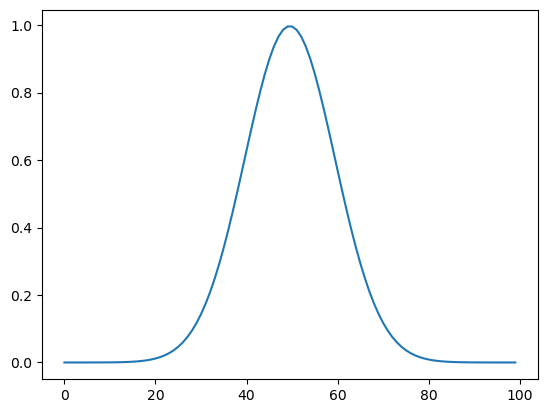

In [2]:
maxs = [np.max(stacked_gaussians[i]) for i in range(stacked_gaussians.shape[0])]

plt.plot(maxs)

#### Average in time of the Gaussians

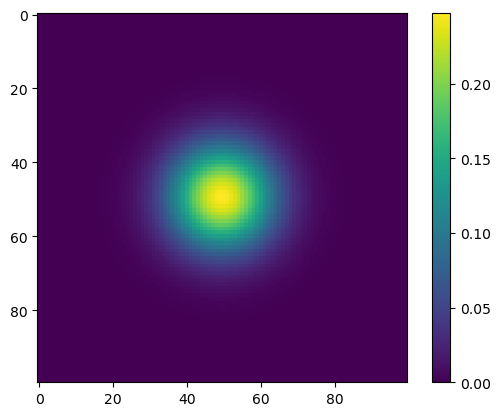

In [3]:
plt.imshow(np.mean(stacked_gaussians, axis = 0))
plt.colorbar()

#### Now let's visualize slices of the datacube: pay attention to the z-axis values

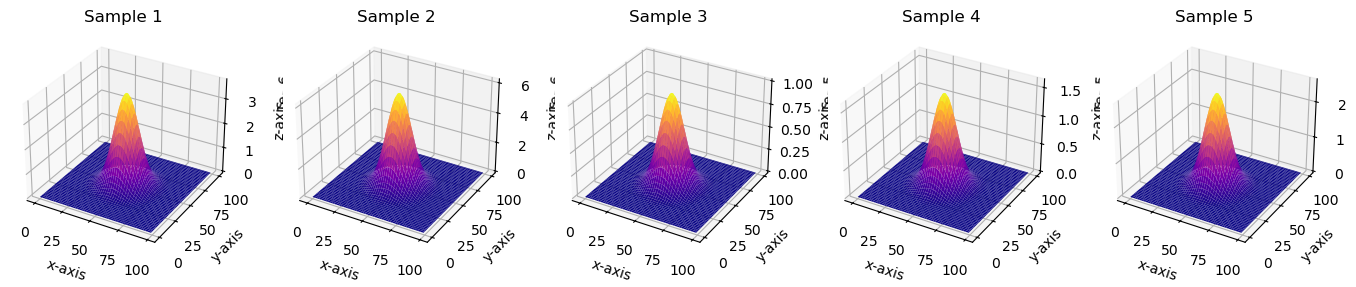

In [14]:
X = np.arange(0, stacked_gaussians.shape[2])
Y = np.arange(0, stacked_gaussians.shape[1])
Y, X = np.meshgrid(X, Y)

samples = np.array([0, 24, 49, 74, 99])

fig = plt.figure(figsize=(17, 4))


for i in range(len(samples)):
    axis = fig.add_subplot(1, 5, i + 1, projection="3d")
    axis.plot_surface(X, Y, stacked_gaussians[i], cmap=plt.cm.plasma)
    axis.set_xlabel("x-axis")
    axis.set_ylabel("y-axis")
    axis.set_zlabel("z-axis")
    axis.set_title(f"Sample {i + 1}")

## Functions to calculate the 3D GP

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern


# We use a Matern kernel to train the GP on our samples. We merge the X and Y dimensions so our process is really 2D, it's just that the spatial component is collapsed.
def train_gaussian_process(xy: np.ndarray, z: np.ndarray) -> GaussianProcessRegressor:
    """
    Train Gaussian Process.

    Parameters
    ----------
    xy : np.ndarray
    z : np.ndarray

    Returns
    -------
    GaussianProcessRegressor

    """
    kernel = Matern(length_scale=4.0, nu=2.5)
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gaussian_process.fit(xy, z)
    return gaussian_process


# We randomly select samples from our gaussian process
def generate_samples_from_gp(
    gaussian_process: GaussianProcessRegressor, points: np.ndarray, sample_size: int
) -> np.ndarray:
    """
    Sample functions from Gaussian Process.

    Parameters
    ----------
    gaussian_process : np.ndarray
    points : np.ndarray
    sample_size : int

    Returns
    -------
    np.ndarray

    """
    return gaussian_process.sample_y(points, n_samples=sample_size)

# Let's draw the samples (blue) and the interpolation from the gaussian process
def draw_samples_3d(
    x: np.ndarray, y: np.ndarray, z: np.ndarray, samples: np.ndarray, points: np.ndarray
) -> None:
    """
    Draw samples.

    Parameters
    ----------
    x : np.ndarray
    y : np.ndarray
    z : np.ndarray
    samples : np.ndarray
    points : np.ndarray

    """

    fig = plt.figure(figsize=(17, 4))

    n = int(np.sqrt(points.shape[0]))
    x_grid = points[:, 0].reshape((n, n))
    y_grid = points[:, 1].reshape((n, n))

    for i in range(samples.shape[1]):
        axis = fig.add_subplot(1, samples.shape[1], i + 1, projection="3d")

        axis.scatter(x, y, z, label="Observations", s=100, alpha=1)
        z_grid = samples[:, i].reshape((n, n))
        axis.plot_surface(x_grid, y_grid, z_grid, cmap=plt.cm.plasma)
        axis.set_xlabel("x-axis")
        axis.set_ylabel("y-axis")
        axis.set_zlabel("z-axis")
        axis.set_title(f"Sample {i + 1}")

    plt.legend()
    plt.tight_layout()
    plt.show()

## Here we compute the 3D-GP

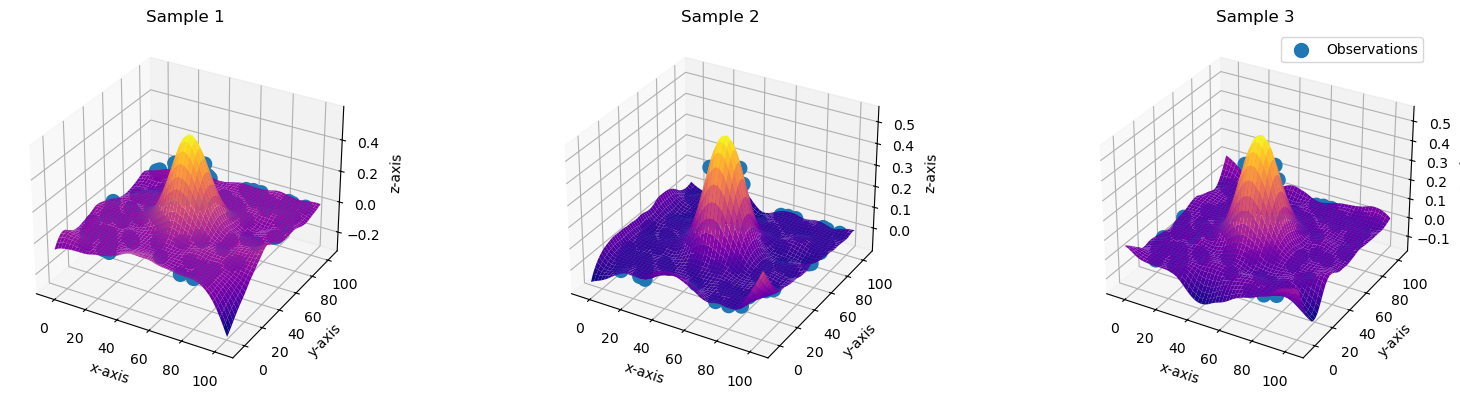

In [65]:
# We use the coordinates of our datacube
x = np.random.randint(0,100, 100)
y = np.random.randint(0,100, 100)

# Grab values of random slices of the 2D gaussians
#z_ind = np.random.randint(0,100,1000) # Uncomment to train GP on several slices
z_ind = (np.ones((y.shape[0]))*39).astype(int) # Uncomment to train GP on one slice

# Grab the values of the datacubes depending on the random indices from above
z = [stacked_gaussians[z_ind[i],y[i],x[i]] for i in range(len(z_ind))]

# Reshaping to work with the functions
x = np.array(x).reshape((-1, 1))
y = np.array(y).reshape(-1, 1)

# Select how many GP functions we want to fit
sample_size = 3 

# Calculate the regressions
gp_regressor_3d = train_gaussian_process(np.column_stack((x, y)), z)

# We shuffle our data to avoid reusing the training dataset
# I'm honestly very insure about what this part does in particular
offset = 5.0 
x_ = np.linspace(min(x) - offset, max(x) + offset, 50)
y_ = np.linspace(min(y) - offset, max(y) + offset, 50)
additional_xy = np.array([[_x, _y] for _x in x_ for _y in y_]).squeeze(-1)

# Grab samples generated from our GPs
samples_3d = generate_samples_from_gp(gp_regressor_3d, additional_xy, sample_size)

# Plot the samples on top of the functions from which they have been sampled
draw_samples_3d(x, y, z, samples_3d, additional_xy)